# Data analysis for stroke liklihood

This project will focus on an analysis of a data-set showing patient health data, and if the patient has suffered a stroke.  The analysis will perform initial data cleanup and validation, linear approaches, KNN approaches, and finally a random forest analysis and SVN.

First, we will import the health data, and show the first few rows to get an idea of the data we are working with:

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split

data = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')
print(data.head())

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  


## Data Analysis and Cleaning

We will start by cleaning the data and verifying we are working with a full data-set.  We will remove rows that are missing important data.

In [2]:
print(f'TOTAL ROWS - {len(data)}')
print(data.isnull().sum())

TOTAL ROWS - 8109
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


First, we see that there are 5110 rows total.  The only field missing data appears to be 'bmi', with 201 rows missing this field.  We will remove those rows, and keep a cleaned data-set.

In [3]:
data = data.dropna()
print(data.isnull().sum())

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


We now have clean data.  Lets evaluate the fields.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7908 entries, 0 to 8108
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7908 non-null   int64  
 1   gender             7908 non-null   object 
 2   age                7908 non-null   float64
 3   hypertension       7908 non-null   int64  
 4   heart_disease      7908 non-null   int64  
 5   ever_married       7908 non-null   object 
 6   work_type          7908 non-null   object 
 7   Residence_type     7908 non-null   object 
 8   avg_glucose_level  7908 non-null   float64
 9   bmi                7908 non-null   float64
 10  smoking_status     7908 non-null   object 
 11  stroke             7908 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 803.2+ KB


ID is not an important column.  Gender, ever_married, work_type, Residence_type, and smoking_status are all strings.  We should change these into a numerical format.  We also want to ensure no special characters are used in naming.

In [5]:
from sklearn.preprocessing import LabelEncoder

data = data.drop('id', axis=1)
data = pd.get_dummies(data, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], drop_first=True)
data.columns = data.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7908 entries, 0 to 8108
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             7908 non-null   float64
 1   hypertension                    7908 non-null   int64  
 2   heart_disease                   7908 non-null   int64  
 3   avg_glucose_level               7908 non-null   float64
 4   bmi                             7908 non-null   float64
 5   stroke                          7908 non-null   int64  
 6   gender_Male                     7908 non-null   bool   
 7   ever_married_Yes                7908 non-null   bool   
 8   work_type_Never_worked          7908 non-null   bool   
 9   work_type_Private               7908 non-null   bool   
 10  work_type_Self_employed         7908 non-null   bool   
 11  work_type_children              7908 non-null   bool   
 12  Residence_type_Urban            7908 no

## Initial analysis

We start our analysis simply - first lets evaluate the correlation matrix:

In [6]:
data.corr()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self_employed,work_type_children,Residence_type_Urban,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_smokes
age,1.000000,0.418016,0.429139,0.396765,0.288711,0.609599,0.036482,0.309876,-0.084187,-0.110670,0.253493,-0.263408,0.016900,0.199030,-0.007650,0.113746
hypertension,0.418016,1.000000,0.409620,0.316036,0.152741,0.395175,0.049861,-0.020457,-0.032770,-0.163561,0.109483,0.029551,0.000305,0.075895,-0.038860,0.061400
heart_disease,0.429139,0.409620,1.000000,0.341367,0.130475,0.440202,0.069805,-0.057871,-0.030659,-0.174821,0.082701,0.062185,-0.007969,0.079939,-0.085334,0.076847
avg_glucose_level,0.396765,0.316036,0.341367,1.000000,0.163308,0.379204,0.068560,-0.015967,-0.028953,-0.158206,0.093653,0.032275,0.008188,0.075617,-0.053594,0.063757
bmi,0.288711,0.152741,0.130475,0.163308,1.000000,0.146680,0.012375,0.158384,-0.027802,0.056073,0.054529,-0.209444,0.019525,0.070776,0.036362,0.074102
stroke,0.609599,0.395175,0.440202,0.379204,0.146680,1.000000,0.068255,-0.067767,-0.032739,-0.208820,0.097817,0.059413,0.020379,0.098893,-0.097862,0.086537
gender_Male,0.036482,0.049861,0.069805,0.068560,0.012375,0.068255,1.000000,-0.031312,0.005792,-0.045095,0.008243,0.058864,-0.004430,0.016636,-0.073951,0.017611
ever_married_Yes,0.309876,-0.020457,-0.057871,-0.015967,0.158384,-0.067767,-0.031312,1.000000,-0.064066,0.140408,0.099172,-0.314804,-0.001232,0.087276,0.095886,0.047881
work_type_Never_worked,-0.084187,-0.032770,-0.030659,-0.028953,-0.027802,-0.032739,0.005792,-0.064066,1.000000,-0.047964,-0.025953,-0.024678,0.018036,-0.026507,0.034777,-0.025196
work_type_Private,-0.110670,-0.163561,-0.174821,-0.158206,0.056073,-0.208820,-0.045095,0.140408,-0.047964,1.000000,-0.446212,-0.424289,-0.014116,-0.022214,0.116364,0.031021


<Axes: >

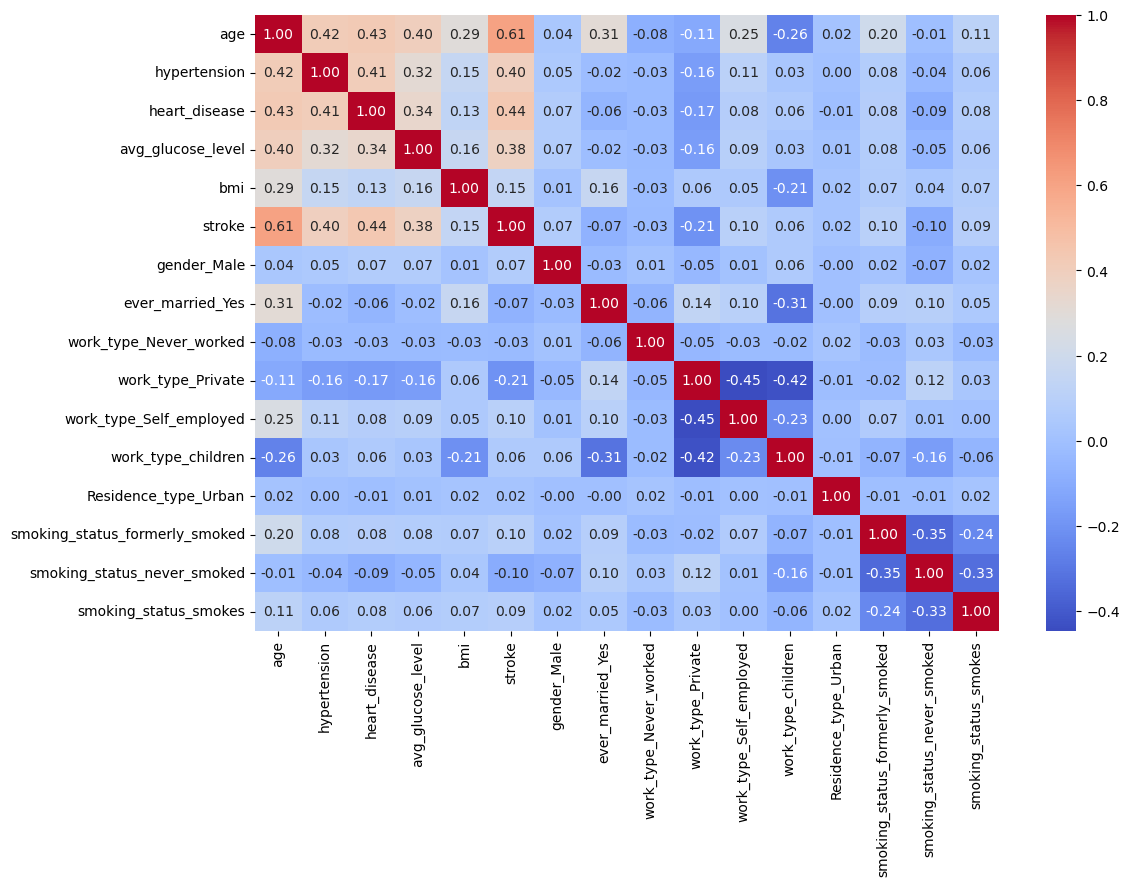

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

A simple correlation matrix shows the highest correlation to our target value, stroke, as age.

## Linear Regression Analysis

Lets start a more thorough analysis, first using linear regression.  We will start with the simple ols function on all columns and order by the adjusted R^2.  We now want to use the train_test_split to get a set of training data, and remove stroke as it is our target.

In [8]:
data_x = data.drop('stroke', axis=1)
data_y = data['stroke']
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=57, stratify=data_y)
y_train.value_counts(normalize=True)

stroke
0    0.722415
1    0.277585
Name: proportion, dtype: float64

In [9]:
import statsmodels.formula.api as smf

linear_r_squared_results = []

for column in X_train.columns:
    formula = f'stroke ~ {column}'
    model = smf.ols(formula, data).fit()
    linear_r_squared_results.append({'feature': column, 'adjusted_r_squared': model.rsquared_adj})

results_df = pd.DataFrame(linear_r_squared_results)
results_df = results_df.sort_values(by='adjusted_r_squared', ascending=False)
print(results_df.to_string)

<bound method DataFrame.to_string of                            feature  adjusted_r_squared
0                              age            0.371532
2                    heart_disease            0.193676
1                     hypertension            0.156056
3                avg_glucose_level            0.143687
8                work_type_Private            0.043485
4                              bmi            0.021391
12  smoking_status_formerly_smoked            0.009655
13     smoking_status_never_smoked            0.009452
9          work_type_Self_employed            0.009443
14           smoking_status_smokes            0.007363
5                      gender_Male            0.004533
6                 ever_married_Yes            0.004466
10              work_type_children            0.003404
7           work_type_Never_worked            0.000946
11            Residence_type_Urban            0.000289>


While the results show some correlation, from the output shown above, we can see that the low adjusted R^2 values mean that we should evalutate this data-set further, using non-linear methods.

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd

poly_r_squared_results = []

for degree in range(1, 21):
    for column in X_train.columns:
        X_feature = X_train[[column]].values
        y_target = y_train.values

        poly = PolynomialFeatures(degree, include_bias=False)
        X_poly = poly.fit_transform(X_feature)

        model = LinearRegression()
        model.fit(X_poly, y_target)
        
        y_pred = model.predict(X_poly)
        r_squared = r2_score(y_target, y_pred)
        
        poly_r_squared_results.append({'feature': column, 'r_squared': r_squared, 'degree': degree})

poly_results_df = pd.DataFrame(poly_r_squared_results)
poly_results_df = poly_results_df.sort_values(by='r_squared', ascending=False)
print(poly_results_df[:3].to_string())

    feature  r_squared  degree
285     age   0.590984      20
195     age   0.588043      14
270     age   0.587711      19


From the analysis above, while we gain some small certainty at a higher degree, the low highest r^2 (at the 20th degree) means no single value has a meaningful impact - we must evaluate the data with other analysis.

## KNN Analysis

We will now evaluate the data using the K-Nearest Neighbors algorithm.  Less than 30% of the data-set represents the positive case, so we will need to scale with class weights to get a better result.

First, lets find the optimal number of nearest neighbors

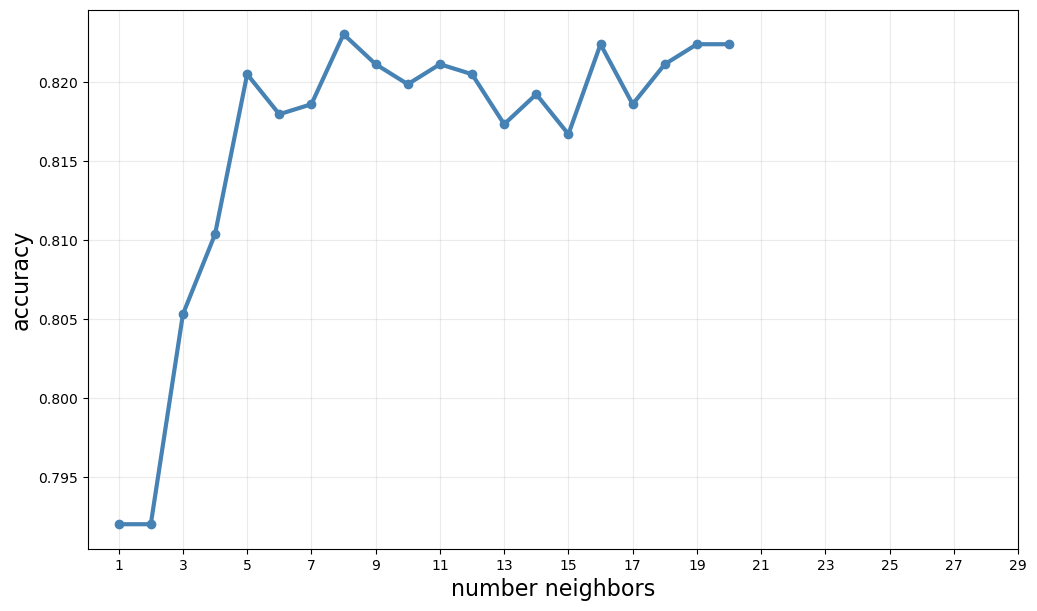

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np


acc = []
wacc = []
allks = range(1,21)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for K in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=K, weights='distance')
    knn = knn.fit(X_train_scaled, y_train)
    
    y_pred = knn.predict(X_test_scaled)
    
    accuracy = np.sum(y_pred == y_test) / len(y_pred)
    
    acc.append(accuracy)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(allks, acc, marker="o", color="steelblue", lw=3, label="unweighted")
ax.set_xlabel("number neighbors", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.xticks(range(1,31,2))
ax.grid(alpha=0.25)


Given the result above, we can see that the accuracy is optimized at 17 nearest neighbors.  Lets use that value for analysis, and output a confusion matrix.

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1143
           1       0.69      0.66      0.67       439

    accuracy                           0.82      1582
   macro avg       0.78      0.77      0.78      1582
weighted avg       0.82      0.82      0.82      1582



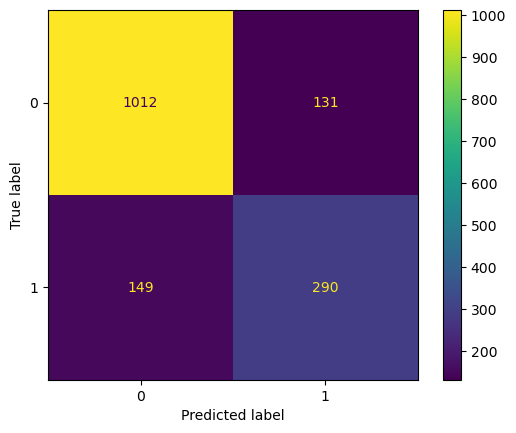

In [12]:
final_knn = KNeighborsClassifier(n_neighbors=8, weights='distance')
final_knn.fit(X_train_scaled, y_train)

y_pred = final_knn.predict(X_test_scaled)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=final_knn.classes_)
print(classification_report(y_test, y_pred, zero_division=0))

As shown in the above confusion matrix, the KNN accuracy with 17 neighbors reaches .96, however due to the positive data only accounting for a little over 4% of the data-set, the model overpredicts on the negative, resulting in an accurate, but unuseful model.  We will need to evaluate this data with another algorythm.

## Random Forest Algorythm

We will now analize the data using a random forest algorythm.

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1143
           1       0.90      0.88      0.89       439

    accuracy                           0.94      1582
   macro avg       0.93      0.92      0.93      1582
weighted avg       0.94      0.94      0.94      1582



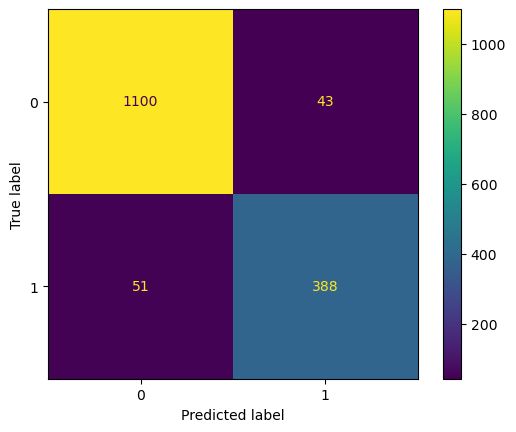

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(class_weight='balanced', random_state=57)

rf.fit(X_train_scaled, y_train)
y_rf_pred = rf.predict(X_test_scaled)

ConfusionMatrixDisplay.from_predictions(y_test, y_rf_pred, labels=rf.classes_)
print(classification_report(y_test, y_rf_pred, zero_division=0))

## Adaboost

We run the same analysis with the Adaboost algorythm.

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1143
           1       0.85      0.89      0.87       439

    accuracy                           0.93      1582
   macro avg       0.90      0.92      0.91      1582
weighted avg       0.93      0.93      0.93      1582



/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


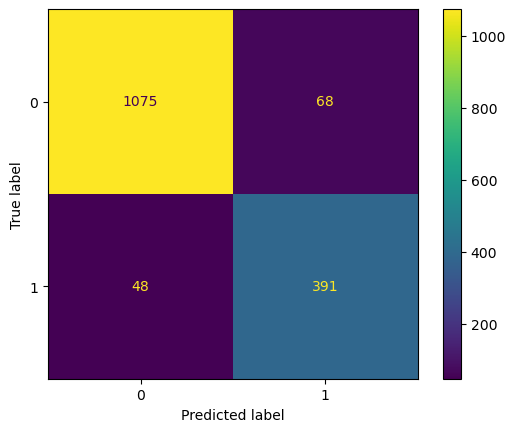

In [14]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

adaboost = AdaBoostClassifier(n_estimators=2000, learning_rate=1.0, random_state=57)

adaboost.fit(X_train_scaled, y_train)

y_ada_pred = adaboost.predict(X_test_scaled)
y_pred_proba = adaboost.predict_proba(X_test)[:, 1]

ConfusionMatrixDisplay.from_predictions(y_test, y_ada_pred, labels=rf.classes_)
print(classification_report(y_test, y_ada_pred, zero_division=0))

As shown above, KNN, Random Forest, and the Adaboost algorythms give similar results - although the Adaboost method does improve results slightly.  The small sample of positives in the training data is certainly having an effect on the accuracy for the model for the positive target value.  A final analysis will be conducted with SVM.

## SVM

We will now try to analize the data using SVM.

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1143
           1       0.69      0.66      0.67       439

    accuracy                           0.82      1582
   macro avg       0.78      0.77      0.78      1582
weighted avg       0.82      0.82      0.82      1582



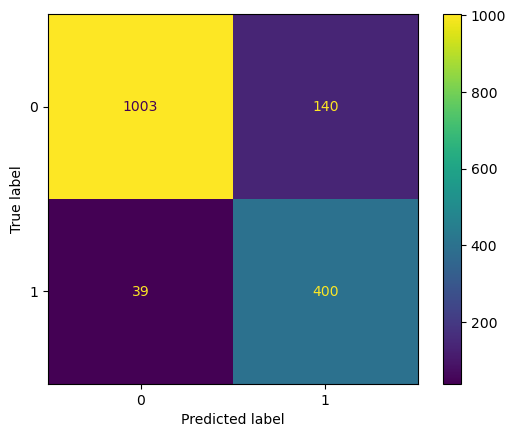

In [15]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

svm = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=57)

svm.fit(X_train_scaled, y_train)

y_svm_pred = svm.predict(X_test_scaled)
y_pred_proba = svm.predict_proba(X_test_scaled)[:, 1]

ConfusionMatrixDisplay.from_predictions(y_test, y_svm_pred, labels=svm.classes_)
print(classification_report(y_test, y_pred, zero_division=0))



The default SVM gives slightly better results, but still has an macro accuracy of .48.

## Grid Search Improvements

As a final analysis, we will try to implement the KNN, Random Forest, and SVM algoritms and improve them using a GridSearch.

In [16]:
# Borrowed from Module 6 Lab, used simply to show data
from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def plotSearchGrid(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid["C"]), len(grid.param_grid["gamma"]))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid["gamma"])), grid.param_grid["gamma"], rotation=45)
    plt.yticks(np.arange(len(grid.param_grid["C"])), grid.param_grid["C"])
    plt.title('Validation accuracy')
    plt.show()
# End plot code

Fitting 5 folds for each of 144 candidates, totalling 720 fits


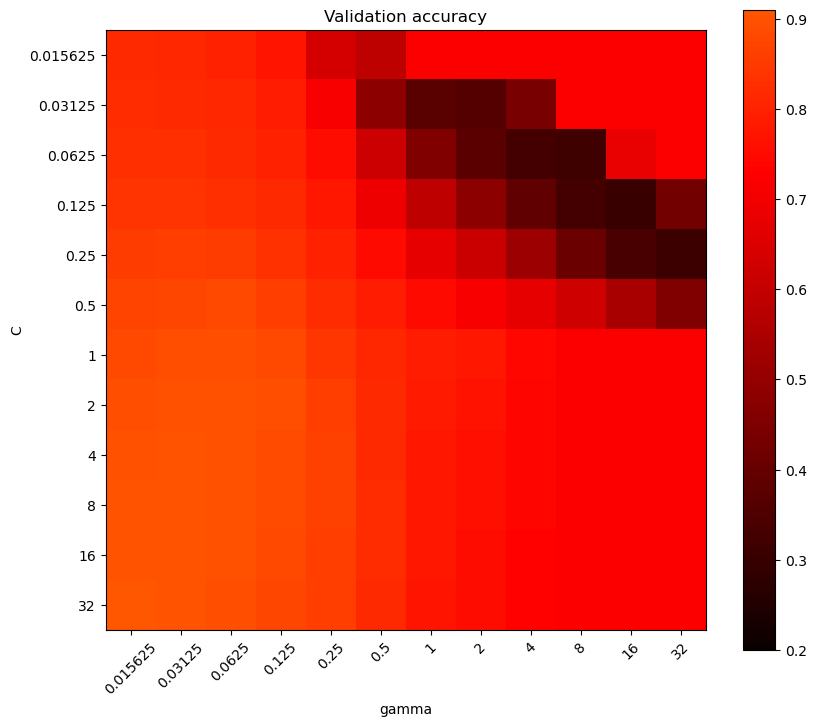

Best Parameters - {'C': 32, 'gamma': 0.015625}


In [17]:
from sklearn.metrics import make_scorer, accuracy_score
param_grid = {
    "C": 8,
    "gamma": 20
}
# Note that large values here are computationally expensive - Commented out after running
# param_grid = {
#     "C": [2**i for i in range(-6, 6)],
#     "gamma": [2**i for i in range(-6, 6)]
# }
macro_accuracy_scorer = make_scorer(accuracy_score, normalize=True)
grid = GridSearchCV(SVC(kernel='rbf',class_weight='balanced', probability=True, random_state=57), param_grid, cv=5, scoring=macro_accuracy_scorer, n_jobs=-1, verbose=1)
grid.fit(X_train_scaled, y_train)
plotSearchGrid(grid)
print(f"Best Parameters - {grid.best_params_}")

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1143
           1       0.69      0.66      0.67       439

    accuracy                           0.82      1582
   macro avg       0.78      0.77      0.78      1582
weighted avg       0.82      0.82      0.82      1582



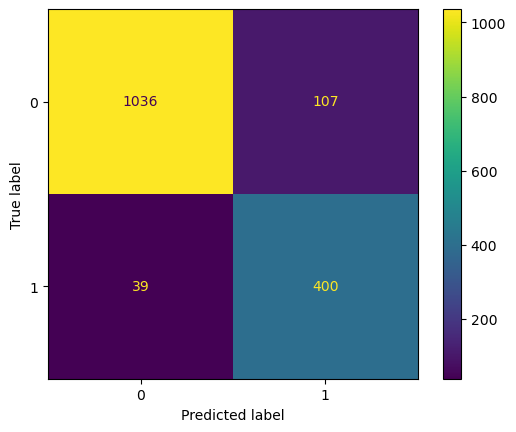

In [18]:
svm = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=57, C=32, gamma=.016)

svm.fit(X_train_scaled, y_train)

y_svm_pred = svm.predict(X_test_scaled)
y_pred_proba = svm.predict_proba(X_test_scaled)[:, 1]

ConfusionMatrixDisplay.from_predictions(y_test, y_svm_pred, labels=svm.classes_)
print(classification_report(y_test, y_pred, zero_division=0))